In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models #add models to the list
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [5]:
root = 'Data/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform = train_transform)

test_data = datasets.ImageFolder(os.path.join(root,'test'),transform = test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)

test_loader = DataLoader(test_data,batch_size=10)

class_names = train_data.classes


In [6]:
train_data.classes

['CAT', 'DOG']

In [7]:
class_names

['CAT', 'DOG']

In [8]:
print(len(train_data), len(test_data))

18743 6251


In [9]:
print(len(train_loader), len(test_loader))

1875 626


In [10]:
for images,labels in train_loader:
    break

In [11]:
images.shape

torch.Size([10, 3, 224, 224])

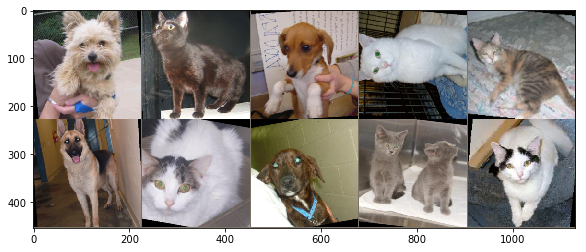

In [12]:
#lest show the 1st 10 images using make_grid() fn

im = make_grid(images,nrow=5) #nrow=5 means each row 5 images

inv_normalize = transforms.Normalize(
    mean = [-0.485/0.229,-0.456/0.224,-0.406/0.225],
    std  = [1/0.229,1/0.224,1/0.225]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))


In [13]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        self.fc1   = nn.Linear(54*54*16,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84,2)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [14]:
((((224-2)/2))-2)/2

54.5

In [15]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [16]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [17]:
sum = 0
for p in model.parameters():
    print(p.numel())
    sum += p.numel()
    
print(f'Total paramters: {sum}')

162
6
864
16
5598720
120
10080
84
168
2
Total paramters: 5610222


In [18]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800 #each batch 10 images --> 8000 images
max_tst_batch = 300 #each batch 10 images --> 3000 images

train_losses = []
test_losses  = []
train_correct= []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b,(X_train,y_train) in enumerate(train_loader,start=1):
        
        # OPTIONAL LIMIT NUMBER OF BATCHES
        #if b == max_trn_batch:
            #break
        
        #train the model
        y_pred = model(X_train)
        
        #calcualte loss
        loss = criterion(y_pred,y_train)
        
        #calculate correct o/ps
        predicted = torch.max(y_pred,1)[1]
        trn_corr += (predicted == y_train).sum()
        
        #update weights and bias
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'Epoch: {i} batch: {b} loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    #TEST SET
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader,start=1):
            
            # OPTIONAL LIMIT NUMBER OF BATCHES
            #if b == max_tst_batch:
                #break

            #train the model
            y_val = model(X_test)
        
            #calculate correct o/ps
            predicted = torch.max(y_val,1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val,y_test)        
    test_losses.append(loss)
    test_correct.append(tst_corr)
        

total_time = time.time() - start_time
print(f'Total time taken: {total_time/60}minutes')

Epoch: 0 batch: 200 loss: 0.7865086197853088
Epoch: 0 batch: 400 loss: 0.7566796541213989
Epoch: 0 batch: 600 loss: 0.48111414909362793
Epoch: 0 batch: 800 loss: 0.5074938535690308
Epoch: 0 batch: 1000 loss: 0.3618032932281494
Epoch: 0 batch: 1200 loss: 0.6499236226081848
Epoch: 0 batch: 1400 loss: 0.6021095514297485
Epoch: 0 batch: 1600 loss: 0.5906923413276672
Epoch: 0 batch: 1800 loss: 0.534054696559906
Epoch: 1 batch: 200 loss: 0.20582394301891327
Epoch: 1 batch: 400 loss: 0.5324565172195435
Epoch: 1 batch: 600 loss: 0.5814159512519836
Epoch: 1 batch: 800 loss: 0.3156750500202179
Epoch: 1 batch: 1000 loss: 0.44812530279159546
Epoch: 1 batch: 1200 loss: 0.5492019653320312
Epoch: 1 batch: 1400 loss: 0.4457797408103943
Epoch: 1 batch: 1600 loss: 0.7759800553321838
Epoch: 1 batch: 1800 loss: 0.3281347155570984
Epoch: 2 batch: 200 loss: 0.3904634118080139
Epoch: 2 batch: 400 loss: 0.2036522626876831
Epoch: 2 batch: 600 loss: 0.42185765504837036
Epoch: 2 batch: 800 loss: 0.32003411650657

In [19]:
torch.save(model.state_dict(), 'Models/my3epochCATDOGModel.pt')

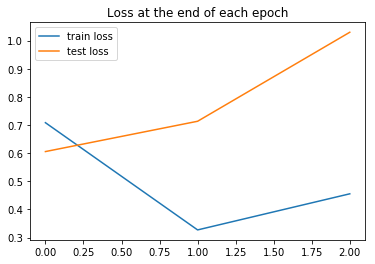

In [20]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss at the end of each epoch')
plt.legend()

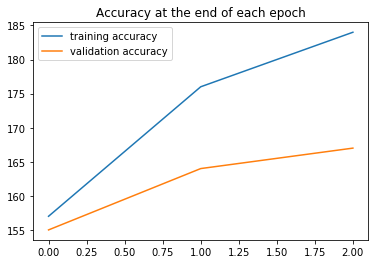

In [21]:
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [22]:
print(f'Accuracy {test_correct[-1].item()*100/3000}')

Accuracy 167.26666666666668


In [24]:
AlexNetmodel = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\mayajai/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth
100.0%


In [37]:
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_featur

In [38]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

In [39]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [40]:
for param in AlexNetmodel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
2048
2


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [42]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.86700118  accuracy:  88.050%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.07982498  accuracy:  90.675%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.07910957  accuracy:  91.900%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.09157297  accuracy:  92.275%

Duration: 524 seconds


In [54]:
print(test_correct[-1].item()*100/3000)

91.36666666666666


# Run a new image through the model¶
We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set

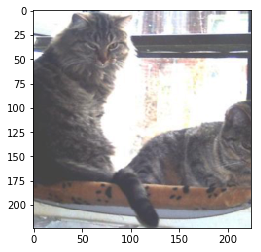

In [56]:
x = 2020
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [57]:
# CNN Model Prediction:

model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT


In [58]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
